# ASTR 540 Homework 2 - Ansh Gupta

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.modeling.powerlaws import Schechter1D as schechter
from astropy.modeling.functional_models import Sersic1D as sersic

## Problem 1

In [2]:
# read in the galaxies datafile, skipping the rows of comments at the top
df = pd.read_csv('Nearbygalaxies.dat', delimiter=' ', skiprows=36, header=None)
m_mask = df[14] == 999. # remove galaxies with magnitude values of 999.
df = df.mask(m_mask)

m = df[14] # apparent V band magnitude
distmod = df[8] # distance modulus
M = m - distmod # using distance modulus relation, calculate absolute V band mag
M = M.values[np.where(~np.isnan(M.values))] # remove nan values masked by pandas
M = np.hstack((M, [-21.1, -20.9])) # add in M31 and MW abs mag from Pritchet+1999

In [3]:
M_min = M.min()//1 # lowest bin edge for histogram
M_max = M.max()//1 + 1 # highest bin edge
delta_M = 1 # histogram bin width in magnitudes

bins = np.arange(M_min, M_max, delta_M) # make bins
n, _ = np.histogram(M, bins=bins) # get counts
M_bins = (bins[:-1] + bins[1:])/2 # get bin centers
nonzero_bin_mask = np.where(~(n == 0))[0] # remove empty bins

n = n[nonzero_bin_mask]
M_bins = M_bins[nonzero_bin_mask]

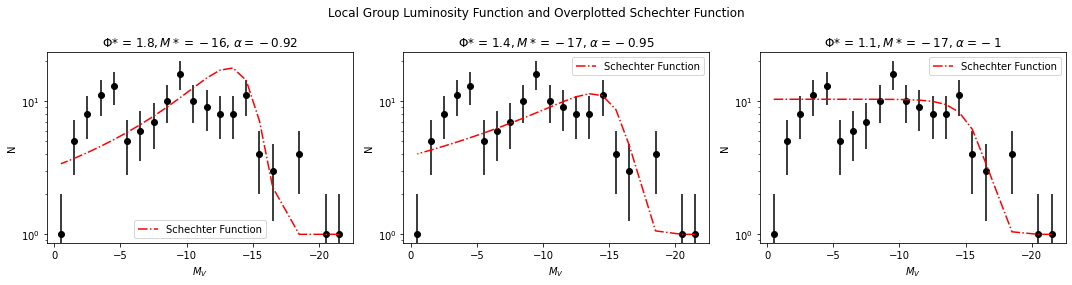

In [4]:
# Through trial and error, these combinations of parameters for the Schechter
# function seem to fit the data decently well
phi_star = [1.8, 1.4, 1.1] # array of values for phi_star
m_star = [-16, -17, -17] # array of values for m_star
alpha = [-0.92, -0.95, -1] # array of values for alpha

# Plot all three Schechter functions over the data
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for i in (0, 1, 2):
    # Schechter function for the given set of parameters
    f = schechter(phi_star=phi_star[i], m_star=m_star[i], alpha=alpha[i])
    
    # I added Poisson errorbars just for fun even though it's not really accurate
    ax[i].errorbar(M_bins, n, yerr=np.sqrt(n), fmt='o', c='k', label='', zorder=1)
    ax[i].plot(M_bins, 10**f(M_bins), c='red', ls='dashdot', label='Schechter Function', zorder=2)
    
    ax[i].set_title(fr'$\Phi$* = {phi_star[i]}$, M* = {m_star[i]}$, $\alpha = {alpha[i]}$')
    ax[i].set_xlabel(r'$M_V$')
    ax[i].set_ylabel('N')
    ax[i].invert_xaxis()
    ax[i].set_yscale('log')
    ax[i].legend()

plt.suptitle('Local Group Luminosity Function and Overplotted Schechter Function')
plt.tight_layout()

As we can see from the above plots, there are a range of values for all of the parameters which produce luminosity functions which are relatively consistent with the data, especially accounting for the large errors associated with the low-number counting statistics of this small sample. The largest variation appears to be in the $\Phi^*$ parameter, which is a normalization constant. The spread in $\alpha$ is pretty small, but even slight changes in this (the power law index of the function) produce wildly different luminosity function shapes. In combination with slightly differening power-law cutoff magnitude ($M^*$), we get a slight variation in the possibly values of $\alpha$ which are consistent with the data.

Making a very crude estimate, $\Phi^* = 1.4 \pm 0.4$, $M^* = -16.5 \pm 0.5$, and $\alpha = -0.95 \pm 0.5$

$M^*$ and $\alpha$ are fairly well constrained, while there is a pretty large uncertainty in $\Phi^*$

However, these uncertainties are just based on this very small sample size and the small range of values that I could get to work, so the actual errors are likely grossly underestimated. In general, it's clear that our results are limited by the lack of galaxies in the faint end, which are biased due to selection effects. It is very difficult to detect and measure with certainty the faintest galaxies in this sample, let alone any fainter ones. The faintest galaxies also will likely have larger error bars on their magnitude values due to the fact that their SNR will be smaller, and since we also have such a small sample, it's very unlikely that we will also see very many galaxies on the high-luminosity end, which might otherwise help constrain some of the parameters.

## Problem 2
See last scanned page

## Problem 3

From equation 1.14 in Sparke and Gallagher,

$m_{\odot} - m = 2.5log_{10}(F) - 2.5log_{10}(F_{\odot})$ \
$ = 2.5log_{10}\left(\frac{L}{4\pi d^2}\right) - 2.5log_{10}\left(\frac{L_{\odot}}{4\pi d_{\odot}^2}\right) $ \
$ = 2.5log_{10}\left(\frac{L}{L_{\odot}} \cdot \frac{d_{\odot}^2}{d^2} \right)$ \
$\frac{L}{L_{\odot}} = 10^{\frac{\left(m_{\odot} - m\right)}{2.5}} \cdot \left(\frac{d}{d_{\odot}}\right)^2$
        

In [5]:
I1 = 15 # surface brightness in mag/arcsec^2
D1 = 20e6 * u.pc # distance in Mpc
M_sun = 4.83 - 0.72 # Sun I band absolute mag from table 1.4 in Sparke and Gallagher

In [6]:
# now just follow the derivation above to get the luminosity in L_sun
m_sun = M_sun + 5*np.log10(u.au.to(u.pc) / 10)
m_diff = m_sun - I1
d_ratio = (D1.to(u.au)/u.au)
L = 10 ** (m_diff/2.5) * (d_ratio**2) # from derivation above

r = D1.value / 206265 # using r = D*theta, with 1 arcsec to radian conversion

# divide by the total area on the sky corresponding to 1 arcsec^2, which will
# be some number of pc^2 to get the final correct units
I1_new = L/r**2 
print(f'Surface brightness in L_sun/pc^2: {I1_new:.6}')

Surface brightness in L_sun/pc^2: 18743.5


Notice that we multiplied by $d^2$ (from the previous derivation), but we also end up dividing by $d^2$ implicitly when we divide out the total on-sky area. This means that this conversion is distance-independent, which makes sense, since we know surface brighness is indeed distance independent.

**So the more distant galaxy with the same surface brightness in the given set of units has the same surface brightness in the converted units too.**

## Problem 4
## a)

In [7]:
m_e = 23.37 # given effective brightness magnitude
I_e = 10**(m_e/-2.5) # effective brightness intensity (kormendy+2009)
r_e = 269.3 # effective/half light radius
n = 6.0 # Sersic profile index

In [8]:
# f = lambda r: Ie * np.exp(-b * ((r/r_e)**(1/n) - 1)), b is constant
# set such that r_e is a half light radius
f = sersic(amplitude=I_e, r_eff=r_e, n=n)
r = np.logspace(-1, 4, 100)
I = f(r)

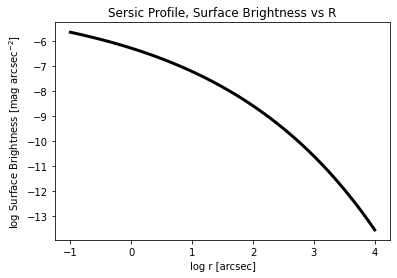

In [9]:
plt.plot(np.log10(r), np.log10(f(r)), color='k', lw=3)

plt.title('Sersic Profile, Surface Brightness vs R')
plt.xlabel('log r [arcsec]')
plt.ylabel(r'log Surface Brightness [mag arcsec$^{-2}$]');

## b)

In [10]:
# m_galaxy - m_sky = -2.5log(I_galaxy / I_sky)
# We want to find the ratio of intensities so we can get the intensity
# of the sky, which we can then multiply by 0.005 and add/subtract from
# the measured sersic profile to account for under/oversubtracting

m_diff = 23.37 - 21.9
I_ratio = 10**(m_diff / -2.5)
I_sky = I/I_ratio
I_excess = I_sky * 0.005

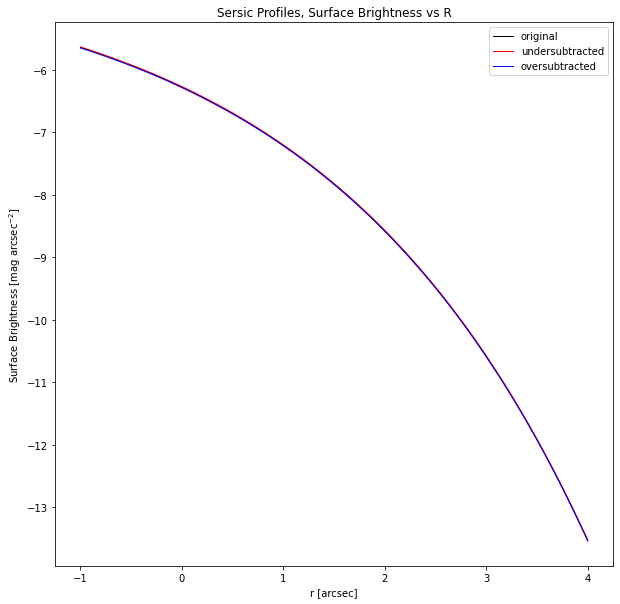

In [11]:
plt.figure(figsize=(10, 10))

plt.plot(np.log10(r), np.log10(f(r)), color='k', lw=1, label='original')
plt.plot(np.log10(r), np.log10(f(r) + I_excess), color='red', lw=1, label='undersubtracted')
plt.plot(np.log10(r), np.log10(f(r) - I_excess), color='blue', lw=1, label='oversubtracted')

plt.title('Sersic Profiles, Surface Brightness vs R')
plt.xlabel('r [arcsec]')
plt.ylabel(r'Surface Brightness [mag arcsec$^{-2}$]')
plt.legend();

What we see from the above is that over or underestimating the sky background by 0.5% doesn't have a very noticable impact on the observed Sersic profile for this galaxy. However, if Kormendy et. al accidentally measured the sky to be too bright, then when they subtracted it out they would have been left with a galaxy that's dimmer than in actuality. In other words, the galaxy's intensity profile would have been oversubtracted, and the resulting intensity profile would be too low (blue line). On the other hand, if the measured sky brightness was too low, then after subtracting it out there would still be some residual contribution to the intensity from the sky that's not actually coming from the galaxy - the galaxy's brightness would be overestimated (red line).

## c)

In [12]:
# Integrate using a simple summation, with a differential area
# element 2*pi*r*dr, and then convert into a magnitude (Kormendy+2009)
M_int = -2.5*np.log10(np.sum(f(r[:-1]) * 2 * np.pi * r[:-1] * np.diff(r)))
print(f'Integrated V Band magnitude: {M_int:.4}')

Integrated V Band magnitude: 7.566


This magnitude is a bit lower (meaning we measure the galaxy to be brighter) than in the Kormendy paper. This is probably because the actual galaxy doesn't perfectly follow a Sersic profile towards its center, but instead has a 'turnoff' at which point the actual brightness is below the profile. Kormendy also seem to have a set a minimum radius of ~3 arcseconds based on their Figure 49, whereas I just integrated over the whole circle on the sky.